# Exercises 12-1 and 12-2 - Time Series Analysis
author: Rachel Nelson

date: 11/7/2020

class: DSC530-T303 Data Exploration and Analysis (2211-1)

## Exercises

**Exercise:**   The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [42]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import thinkplot
import thinkstats2
import regression
import timeseries


In [58]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
transactions.head()
transactions.describe()

,price,amount,ppg,lat,lon
count,147070.000000,147070.000000,147070.000000,146897.000000,146897.000000
mean,137.259516,15.336626,10.670560,37.858994,-91.988509
std,120.217590,11.145683,5.622977,5.008867,16.545298
min,4.000000,1.000000,1.020000,24.675731,-124.399110
25%,50.000000,5.000000,6.000000,33.990380,-104.804560
50%,100.000000,14.150000,10.600000,38.952526,-86.785248
75%,200.000000,28.300000,14.130000,41.598235,-79.107692
max,990.000000,28.300000,34.980000,49.054587,-67.086970


In [77]:
# Quadradic Model Function for prices by year
def RunQuadraticModel(daily):
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results


In [78]:
# Runs the Group by Quality and Day function in timeseries.py and saves it as "dailies"
dailies = timeseries.GroupByQualityAndDay(transactions)

#Creates Daily Group based on dailies
name = 'high'
daily = dailies[name]

# Runs Quadratic Model on the daily group and includes report summary
model, results = RunQuadraticModel(daily)
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sat, 07 Nov 2020   Prob (F-statistic):          4.57e-164
Time:                        12:27:26   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

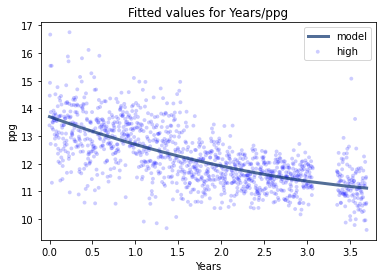

In [87]:
timeseries.PlotFittedValues(model, results, label=name)
thinkplot.Config(title='Fitted values for Years/ppg',
                 xlabel='Years',
                 xlim=[-0.1, 3.8],
                 ylabel='ppg')

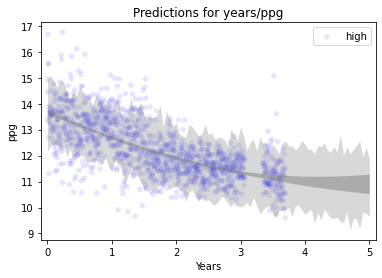

In [88]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
timeseries.PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(title='Predictions for years/ppg',
                 xlabel='Years',
                 xlim=[years[0]-0.1, years[-1]+0.1],
                 ylabel='ppg')

**Exercise:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [53]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(thinkstats2.SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [54]:
def TestSerialCorr(daily):
    # test the correlation between consecutive prices
    series = daily.ppg
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    print(test.actual, pvalue)

    # test for serial correlation in residuals of the linear model
    _, results = timeseries.RunLinearModel(daily)
    series = results.resid
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    print(test.actual, pvalue)

    # test for serial correlation in residuals of the quadratic model
    _, results = RunQuadraticModel(daily)
    series = results.resid
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    print(test.actual, pvalue)

In [55]:
TestSerialCorr(daily)



0.485229376194738 0.0
0.07570473767506261 0.011
0.05607308161289916 0.055
